Group Members
- Jonathan Conn
- Matt Boulden
- Arunam Gupta


In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import numpy as np
from sklearn import preprocessing
import glob
import datetime

import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats

#### Covid Data
Data downloaded from https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports_us. This data is about Coronavirus infections in each state in the United States on a daily basis. The code below combines all csv files for each and puts them in a single Pandas dataframe. The second part of this code converts all date and time to datetime objects for better usage.

In [2]:
path = 'covid_data'
all_files = glob.glob(path + "/*.csv")

li = []

# reading each seperate csv file into list of dataframes
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

# building single dataframe from list
covid_df = pd.concat(li, axis=0, ignore_index=True)

# dropping rows with missing dates, ~20 of them
covid_df.dropna(subset=['Last_Update'], inplace=True)

# dropping US territories from dataset
covid_df.drop(covid_df.loc[covid_df['ISO3'] != 'USA'].index, inplace=True)

# dropping cruise ships from dataset
cruise_ships = ['Diamond Princess', 'Grand Princess']
covid_df.drop(covid_df.loc[covid_df['Province_State'].isin(cruise_ships)].index, inplace=True)


# dropping cols with data not needed
covid_df.drop(
    columns=['Country_Region', 'Lat', 'Long_', 
             'People_Hospitalized', 'FIPS', 'UID', 'ISO3', 
             'Hospitalization_Rate', 'Total_Test_Results', 
             'Case_Fatality_Ratio'], inplace=True)

# converting dates to datetime types
covid_df['Last_Update'] = pd.to_datetime(covid_df.Last_Update)

covid_df.columns = ['State', 'Date', 'Cases', 'Deaths', 'Recovered', 'Active', 'Incident_Rate', 'People_Tested', 'Mortality_Rate', 'Testing_Rate']

covid_df.head(5)

,State,Date,Cases,Deaths,Recovered,Active,Incident_Rate,People_Tested,Mortality_Rate,Testing_Rate
0,Alabama,2020-08-07 04:35:29,97044,1714,37923.0,56955.0,1969.984816,739784.0,1.774474,15087.825566
1,Alaska,2020-08-07 04:35:29,3483,25,1220.0,2238.0,476.115618,261572.0,0.717772,35756.105229
3,Arizona,2020-08-07 04:35:29,183656,4002,24531.0,155123.0,2523.191931,995864.0,2.179074,13681.861790
4,Arkansas,2020-08-07 04:35:29,47028,515,39555.0,6958.0,1558.351702,539836.0,1.095092,17888.371809
5,California,2020-08-07 04:35:29,541339,10021,NaN,531318.0,1370.054527,8500463.0,1.851151,21513.502290


## Making the data relevant:
In the following code, we decided to convert the covid data to something that can be measured instaneously, the current days infection rate. This was done by finding the change in current/active cases and dividing it by the previous days active cases. We believed this to be a more accurate measurement, as gaining 1000 cases when the total cases are 2000, vs when total cases are 1,000,000, are two very different concepts. Because a linear regression model cannot distinguish between the two, we believed tracking the spike, or decline, of covid cases, to be a more accurate way to estimate the result on stock prices at that time.

This data is different from the above data, in that it looks at world data rather than specifically that of the USA. This is what we will be using for our hypothesis testing, because Covid-19 had start impacted the US economy before any cases had arrived in the US.

In [3]:
# this should be the dataset we actually use
#### put manipulation of actual data here
df = pd.read_csv("day_wise.csv", index_col=None, header=0) # this should be the dataset we actually use
#### put manipulation of actual data here
#creating a % change in the df
df = df.drop(['Recovered','No. of countries','Recovered / 100 Cases','New recovered','Confirmed' ],axis = 1)
df['Date'] = pd.to_datetime(df['Date'])
df['% daily change'] = np.nan
df['% daily change'][0] = 0.0
i = 1
while (i <= 187):
    df['% daily change'][i] = (df['Active'][i] - df['Active'][i-1]) / df['Active'][i-1]
    i = i + 1
#reserving this dataframe to be used for hypothesis testing later
daily_df = df.copy(deep=True)
dummy = df.copy(deep=True)
daily_df.head(5)

<ipython-input-3-2b442b37b81a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['% daily change'][0] = 0.0
<ipython-input-3-2b442b37b81a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['% daily change'][i] = (df['Active'][i] - df['Active'][i-1]) / df['Active'][i-1]


,Date,Deaths,Active,New cases,New deaths,Deaths / 100 Cases,Deaths / 100 Recovered,% daily change
0,2020-01-22,17,510,0,0,3.06,60.71,0.000000
1,2020-01-23,18,606,99,1,2.75,60.00,0.188235
2,2020-01-24,26,879,287,8,2.76,72.22,0.450495
3,2020-01-25,42,1353,493,16,2.93,107.69,0.539249
4,2020-01-26,56,2010,684,14,2.64,107.69,0.485588


In [4]:
total_df = pd.DataFrame()

cases = covid_df.groupby(covid_df['Date'].dt.day)['Cases'].sum()
deaths = covid_df.groupby(covid_df['Date'].dt.day)['Deaths'].sum()


for i, df in covid_df.groupby(covid_df['Date'].dt.day):
    temp = {}
    
    temp['Date'] = df['Date'].iloc[0]
    
    for j in ['Cases', 'Deaths', 'Recovered', 'Active', 'People_Tested']:
        temp[j] = df[j].sum()
        
    for j in ['Incident_Rate', 'Mortality_Rate', 'Testing_Rate']:
        temp[j] = df[j].mean()
    
    total_df = total_df.append(temp, ignore_index=True)
    
total_df = total_df[['Date', 'Active', 'Cases', 'Deaths', 'Recovered', 
                     'People_Tested', 'Incident_Rate', 'Mortality_Rate',
                    'Testing_Rate']]

total_df = total_df.sort_values('Date')
total_df.head(5)


,Date,Active,Cases,Deaths,Recovered,People_Tested,Incident_Rate,Mortality_Rate,Testing_Rate
17,2020-04-18 22:32:47,24366707.0,39477538.0,1218767.0,13867541.0,366202867.0,1419.631767,3.365281,21038.109741
20,2020-04-21 23:40:34,25194532.0,40891473.0,1245160.0,14417523.0,380337166.0,1478.865371,3.370841,21888.591919
29,2020-04-30 02:32:31,27605839.0,45127463.0,1321982.0,16254346.0,428434031.0,1653.830986,3.331165,24507.237953
9,2020-05-10 02:32:34,30826497.0,50857077.0,1416362.0,18481810.0,325978589.0,1890.969391,3.407908,27481.761489
27,2020-05-28 02:32:37,27065956.0,44184251.0,1304612.0,15819733.0,416756668.0,1615.602593,3.331057,23800.864123


#### US Economy Baseline
The Dow Jones Industrial Average tracks the 30 largest US companies.  
The S&P 500 tracks the 500 largest US companies and represents 75% of all publicly traded stocks.  
The Nasdaq tracks ~3,000 companies traded on the Nasdaq exchange, while the former two use the NY exchange.  
Together, these market indexes are used to determine how the US economy is performing.

In [5]:
dow_df = pd.read_csv('data/dow_data.csv')
nas_df = pd.read_csv('data/nasdaq_data.csv')
sp_df = pd.read_csv('data/s&p_data.csv')

dow_df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-16,28191.669922,28337.490234,28191.669922,28235.890625,28235.890625,286770000
1,2019-12-17,28221.750000,28328.630859,28220.560547,28267.160156,28267.160156,286770000
2,2019-12-18,28291.439453,28323.250000,28239.279297,28239.279297,28239.279297,289890000
3,2019-12-19,28278.310547,28381.480469,28278.240234,28376.960938,28376.960938,262570000
4,2019-12-20,28608.640625,28608.640625,28445.599609,28455.089844,28455.089844,603780000


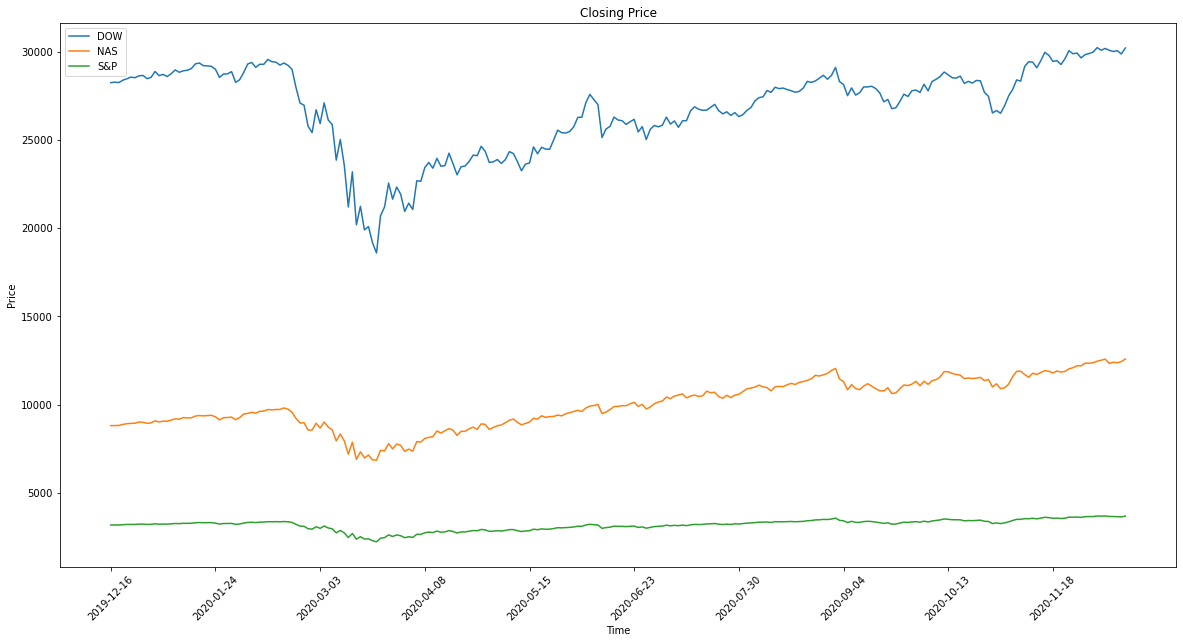

In [6]:
figure(figsize=(20, 10))
plt.plot(dow_df['Date'], dow_df['Close'], label='DOW')
plt.plot(nas_df['Date'], nas_df['Close'], label='NAS')
plt.plot(sp_df['Date'], sp_df['Close'], label='S&P')

plt.title('Closing Price')
plt.xlabel('Time')
plt.ylabel('Price')

plt.xticks(dow_df['Date'], dow_df['Date'], rotation=45)
plt.locator_params(axis='x', nbins=10)
plt.legend()

plt.show()

#### Standardizing Our Data 
The price points of each index are vastly different.  
To make a good comparison we are going to normalize the data, aggregate it, and visualize it.  
We are going to call this new dataframe our Master and it will represent the US economy.

In [7]:
# seperating price data for each index
price_dow = dow_df[['Open', 'High', 'Low', 'Close']]
price_nas = nas_df[['Open', 'High', 'Low', 'Close']]
price_sp = sp_df[['Open', 'High', 'Low', 'Close']]

# normalizing each index individually
norm_dow = (price_dow - price_dow.mean()) / price_dow.std()
norm_nas = (price_nas - price_nas.mean()) / price_nas.std()
norm_sp = (price_sp - price_sp.mean()) / price_sp.std()

# adding backs correct datetime
norm_dow.insert(loc=0, column='Date', value=dow_df['Date'])
norm_nas.insert(loc=0, column='Date', value=nas_df['Date'])
norm_sp.insert(loc=0, column='Date', value=sp_df['Date'])

norm_dow['Date'] = pd.to_datetime(norm_dow.Date)
norm_nas['Date'] = pd.to_datetime(norm_nas.Date)
norm_sp['Date'] = pd.to_datetime(norm_sp.Date)

norm_dow.head(5)

,Date,Open,High,Low,Close
0,2019-12-16,0.564158,0.555093,0.633392,0.583475
1,2019-12-17,0.576487,0.551317,0.644736,0.596283
2,2019-12-18,0.605051,0.549023,0.652086,0.584863
3,2019-12-19,0.599670,0.573844,0.667385,0.641259
4,2019-12-20,0.735065,0.670674,0.733100,0.673262


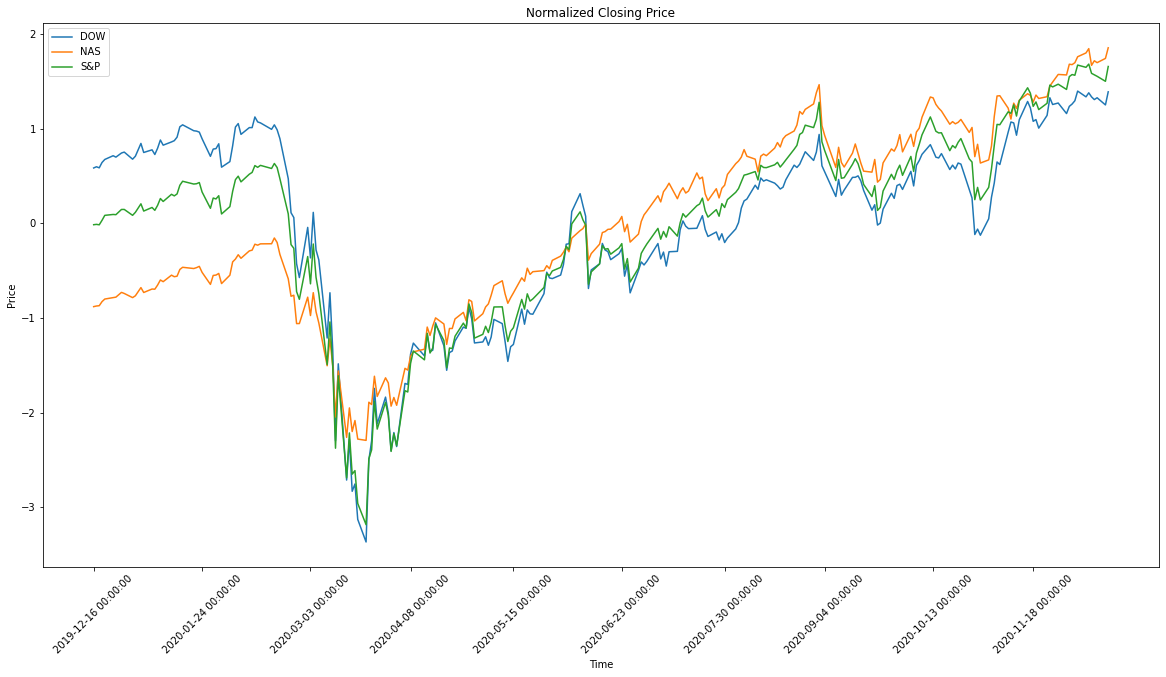

In [8]:
figure(figsize=(20, 10))
plt.plot(norm_dow['Date'], norm_dow['Close'], label='DOW')
plt.plot(norm_nas['Date'], norm_nas['Close'], label='NAS')
plt.plot(norm_sp['Date'], norm_sp['Close'], label='S&P')

plt.title('Normalized Closing Price')
plt.xlabel('Time')
plt.ylabel('Price')

plt.xticks(norm_dow['Date'], norm_dow['Date'], rotation=45)
plt.locator_params(axis='x', nbins=10)
plt.legend()

plt.show()

In [9]:
# cloning data to modify
label_dow = price_dow
label_nas = price_nas
label_sp = price_sp

# labeling each index correctly for when we aggresgrate them togethers
label_dow.insert(loc=0, column='Index', value='DOW')
label_nas.insert(loc=0, column='Index', value='NAS')
label_sp.insert(loc=0, column='Index', value='S&P')

label_dow.insert(loc=0, column='Date', value=dow_df['Date'])
label_nas.insert(loc=0, column='Date', value=nas_df['Date'])
label_sp.insert(loc=0, column='Date', value=sp_df['Date'])

# creating master dataframe
master_df = pd.concat([label_dow, label_nas, label_sp], ignore_index=True)

# converting dates to correct datatime type, sorting, and reindexing
master_df['Date'] = pd.to_datetime(master_df.Date)
master_df = master_df.sort_values('Date')

master_df = master_df.reset_index(drop=True)

master_df

,Date,Index,Open,High,Low,Close
0,2019-12-16,DOW,28191.669922,28337.490234,28191.669922,28235.890625
1,2019-12-16,NAS,8791.309570,8833.450195,8789.769531,8814.230469
2,2019-12-16,S&P,3183.629883,3197.709961,3183.629883,3191.449951
3,2019-12-17,DOW,28221.750000,28328.630859,28220.560547,28267.160156
4,2019-12-17,NAS,8829.469727,8831.990234,8804.599609,8823.360352
...,...,...,...,...,...,...
754,2020-12-14,DOW,30123.910156,30325.789063,29849.150391,29861.550781
755,2020-12-14,NAS,12447.440430,12543.000000,12432.709961,12440.040039
756,2020-12-15,NAS,12543.259766,12596.129883,12465.419922,12595.059570
757,2020-12-15,DOW,29919.089844,30243.259766,29894.949219,30199.310547


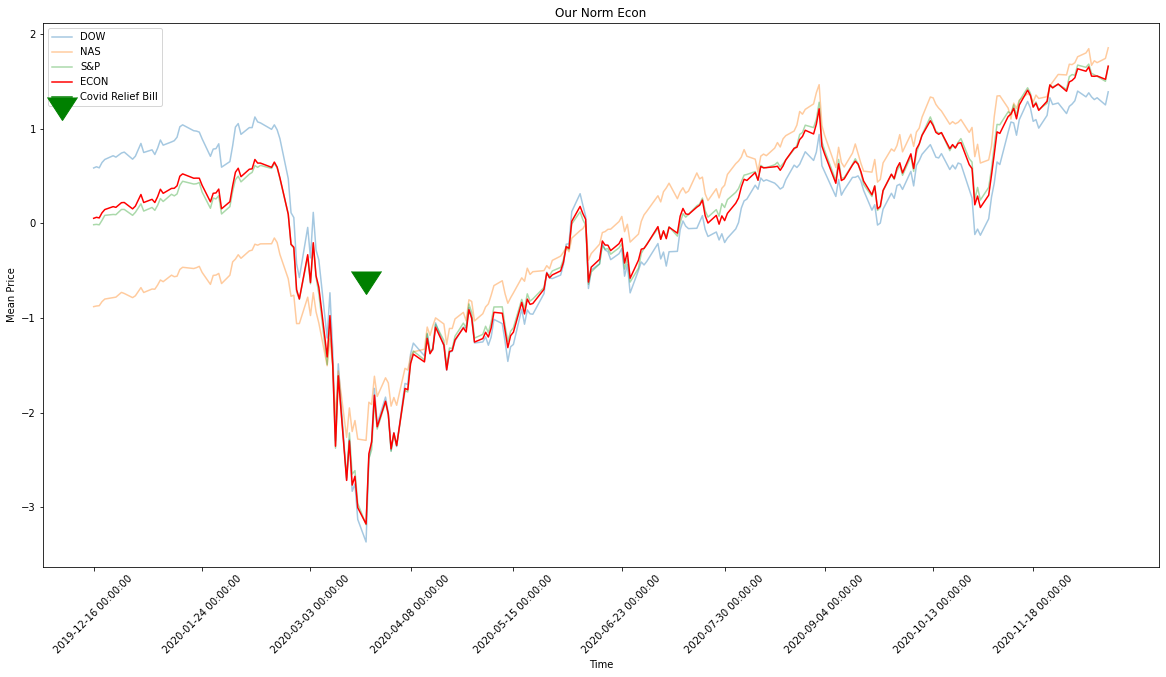

In [10]:
figure(figsize=(20, 10))

# sum each index for every date and mean normalizing
df = master_df.groupby(master_df.index // 3).sum()
norm_df = (df - df.mean()) / df.std()

# appending dates back for graphing 
norm_df.insert(loc=0, column='Date', value=dow_df['Date'])
norm_df = norm_df.sort_values('Date')

norm_df['Date'] = pd.to_datetime(norm_df.Date)

plt.plot(norm_dow['Date'], norm_dow['Close'], label='DOW', alpha=0.4)
plt.plot(norm_nas['Date'], norm_nas['Close'], label='NAS', alpha=0.4)
plt.plot(norm_sp['Date'], norm_sp['Close'], label='S&P', alpha=0.4)

plt.plot(norm_df['Date'], norm_df['Close'], color='red', label='ECON')

plt.plot(datetime.datetime(2020,3,23), -0.5, marker=11, markersize=30, color='green', label='Covid Relief Bill')

plt.title('Our Norm Econ')
plt.xlabel('Time')
plt.ylabel('Mean Price')

plt.xticks(norm_df['Date'], norm_df['Date'], rotation=45)
plt.locator_params(axis='x', nbins=10)
plt.legend()
plt.show()

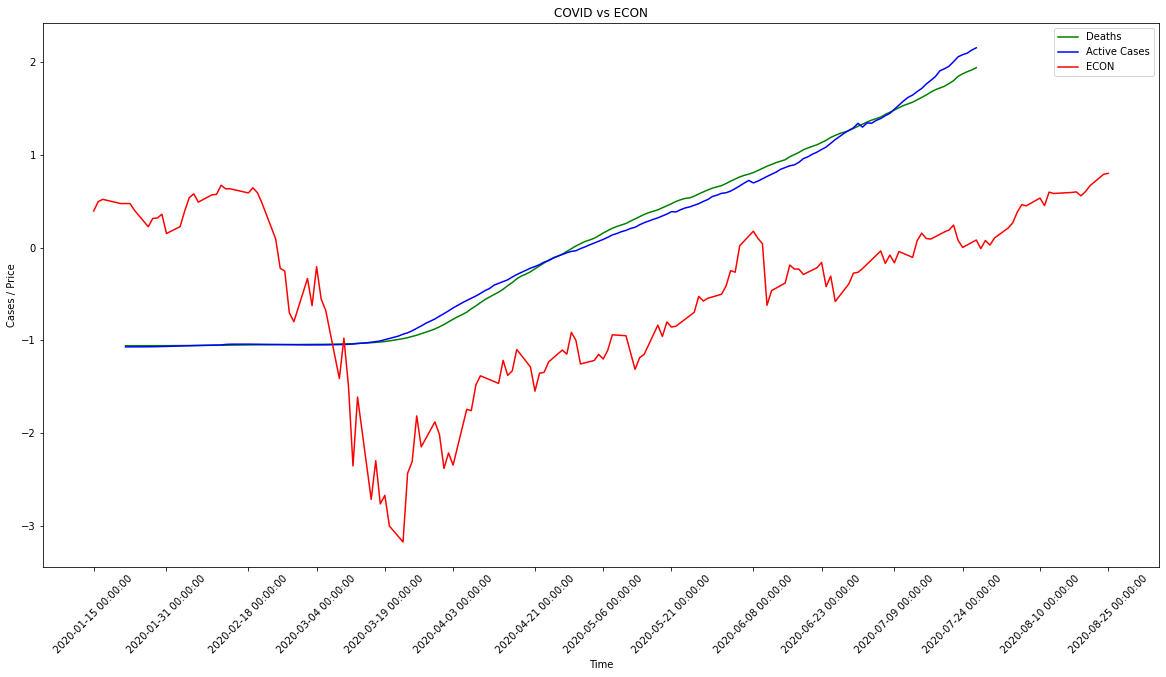

In [11]:
figure(figsize=(20, 10))

# sum each index for every date and mean normalizing
ndaily_df = daily_df.copy(deep=True)
ndaily_df = ndaily_df[['Date', 'Active', 'Deaths']]

ndaily_df = ndaily_df.sort_values('Date')
ndaily_df['Active'] = (ndaily_df['Active'] - ndaily_df['Active'].mean()) / ndaily_df['Active'].std()
ndaily_df['Deaths'] = (ndaily_df['Deaths'] - ndaily_df['Deaths'].mean()) / ndaily_df['Deaths'].std()

temp_df = norm_df.copy(deep=True)
temp_df = temp_df.iloc[20:175]
temp_df = temp_df.reset_index(drop = True)

plt.plot(ndaily_df['Date'], ndaily_df['Deaths'], color='green', label='Deaths')
plt.plot(ndaily_df['Date'], ndaily_df['Active'], color='blue', label='Active Cases')
plt.plot(temp_df['Date'], temp_df['Close'], color='red', label='ECON')

plt.title('COVID vs ECON')
plt.xlabel('Time')
plt.ylabel('Cases / Price')

plt.xticks(temp_df['Date'], temp_df['Date'], rotation=45)
plt.locator_params(axis='x', nbins=15)

plt.legend()
plt.show()

### Hypothesis Formulation and Testing:
Our intial hypothesis is that the Covid-19 case rate, as well as  death rate, will be negatively correlated with stock prices. There may be some variability in this due to different press releases and policy changes having a large, sudden impact on the market, but overall we expect these things to be mainly influenced by the infection and mortality rate.

To test this, we plan to use machine learning to attempt to create a predictive model for our data, using covid death and infection rates as the independent variables/predictors, and the stock market our dependent or test variable.

In [12]:
dummy = daily_df.sort_values('Date')
i = 0
holidays = [datetime.datetime(2020, 2, 17), datetime.datetime(2020, 4, 10), datetime.datetime(2020, 5, 25), datetime.datetime(2020, 7, 3)]
dummy.drop(dummy.loc[dummy['Date'].isin(holidays)].index, inplace=True)
dummy = dummy.reset_index(drop = True)
while (i < 184):

    if (dummy['Date'][i].weekday() > 4):
        dummy = dummy.drop([i])
    i += 1
dummy = dummy.iloc[1:]
dummy = dummy.reset_index(drop=True)

dummy['Date'] = pd.to_datetime(dummy['Date'])
dummy.head(5)

,Date,Deaths,Active,New cases,New deaths,Deaths / 100 Cases,Deaths / 100 Recovered,% daily change
0,2020-01-23,18,606,99,1,2.75,60.00,0.188235
1,2020-01-24,26,879,287,8,2.76,72.22,0.450495
2,2020-01-27,82,2784,809,26,2.80,134.43,0.385075
3,2020-01-28,131,5340,2651,49,2.35,122.43,0.918103
4,2020-01-29,133,5908,588,2,2.16,106.40,0.106367


### Converting Dow Jones Data into daily % change:

In [13]:
# this is just where I'm messing with dow data   ndaily_df = ndaily_df.sort_values('Date')
# Creating daily % gain to try and make the data comparable to covid infection rate
df2 = price_dow.sort_values('Date')
df2['Date'] = pd.to_datetime(df2['Date'])

df2 = df2.drop(['High','Low'],axis = 1)
i = 0
df2['% daily change'] = np.nan
while (i < 253):
    df2['% daily change'][i] = (df2['Close'][i] - df2['Open'][i]) / df2['Open'][i]
    i = i + 1
df2 = df2.iloc[25:]
df2 = df2.reset_index(drop = True)
df2 = df2.iloc[:129]
df2 = df2.reset_index(drop = True)
df2

<ipython-input-13-60d4f79320e5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['% daily change'][i] = (df2['Close'][i] - df2['Open'][i]) / df2['Open'][i]


,Date,Index,Open,Close,% daily change
0,2020-01-23,DOW,29111.019531,29160.089844,0.001686
1,2020-01-24,DOW,29230.390625,28989.730469,-0.008233
2,2020-01-27,DOW,28542.490234,28535.800781,-0.000234
3,2020-01-28,DOW,28594.279297,28722.849609,0.004496
4,2020-01-29,DOW,28820.529297,28734.449219,-0.002987
...,...,...,...,...,...
124,2020-07-21,DOW,26833.140625,26840.400391,0.000271
125,2020-07-22,DOW,26824.560547,27005.839844,0.006758
126,2020-07-23,DOW,26955.970703,26652.330078,-0.011264
127,2020-07-24,DOW,26533.410156,26469.890625,-0.002394


In [14]:
covidRate = dummy['% daily change'].values.reshape(-1,1)
marketRate = df2['% daily change'].values.reshape(-1,1)
clf = LinearRegression().fit(covidRate, marketRate)

In [15]:
clf.coef_

array([[0.00753099]])

In [16]:
clf.intercept_

array([-0.0009094])

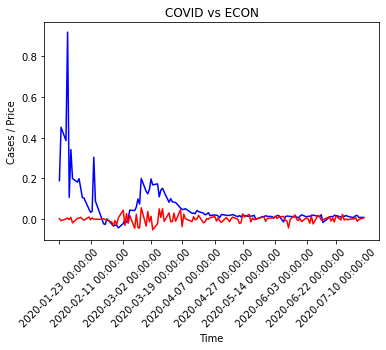

In [17]:
plt.plot(dummy['Date'], dummy['% daily change'], color='blue', label='COVID')
plt.plot(df2['Date'], df2['% daily change'], color='red', label='ECON')

plt.title('COVID vs ECON')
plt.xlabel('Time')
plt.ylabel('Cases / Price')

plt.xticks(df2['Date'], df2['Date'], rotation=45)
plt.locator_params(axis='x', nbins=10)
#plt.legend()
plt.show()

# Analysis:
After looking at the results of our linear regression model, particularly the tiny, positive coefficent of .007531,  it is clear that the volatility of the stock market is not very highly correlated with an increase or decrease in the number of Coronavirus cases. Seeing that there is actually a slight positive correlation says to us that this is probably not a very good indicator for how the market will fare. Though at the dawn of coronavirus there is an undeniable immediate crash in the market as reports came out and quarantines were put in place, it is clear that the effects of it's presence dwindled after hysteria died down, and the government began rolling out stimulus packages. It is clear then that neither the number of cases, nor the rate of increase in cases, had a consistent impact on the market, but rather just caused an initial crash that was soon overcome.

One of the problems we believe with our model is that stock prices are not tied to the actual state of the economy, but what the public's perception of the economy is. When a large amount of money was released to the public in the form of a stimulus bill, a clear positive shift can be seen in the graphs above that essentially ended the stock crash America was experiencing in March, regardless of the fact that businesses would continue to be shut down for months to come.

## Further Reading
https://www.nber.org/papers/w27576 - The Effect of Fiscal Stimulus: Evidence from COVID-19

https://www.cepal.org/en/publications/45984-impact-covid-19-united-states-economy-and-policy-response - Impact of COVID-19 on the United States economy and the policy response

https://www.brookings.edu/blog/up-front/2020/03/23/how-will-the-coronavirus-affect-state-and-local-government-budgets/ - How will the coronavirus affect state and local government budgets?

https://www.fitchratings.com/research/sovereigns/deep-global-recession-in-2020-as-coronavirus-crisis-escalates-02-04-2020 - Deep Global Recession in 2020 as Coronavirus Crisis Escalates

https://www.wri.org/blog/2020/03/coronavirus-US-economic-stimulus - US Coronavirus Response: 3 Principles for Sustainable Economic Stimulus